In [1]:
"""Sanity check on booth function. All optimizers should converge."""
import pytest
import torch
import torchzero as tz

def booth(x,y):
    return (x + 2 * y - 7) ** 2 + (2 * x + y - 5) ** 2

x0 = (0, -8)

def _test_optimizer(lmbda, tol=1e-1):
    params = torch.tensor(x0, dtype=torch.float32, requires_grad=True)
    opt = lmbda([params])
    
    def closure(backward=True):
        loss = booth(*params)
        if backward:
            opt.zero_grad()
            loss.backward()
        return loss
    
    losses = []
    for i in range(100):
        loss = opt.step(closure)
        losses.append(loss)
        assert isinstance(loss, torch.Tensor), (i, type(loss), loss)
        assert torch.isfinite(loss), (i, loss)
        
    assert loss <= tol, (tol, loss, [i.detach().cpu().item() for i in losses])
    print(opt.__class__.__name__, loss.detach().cpu().item())

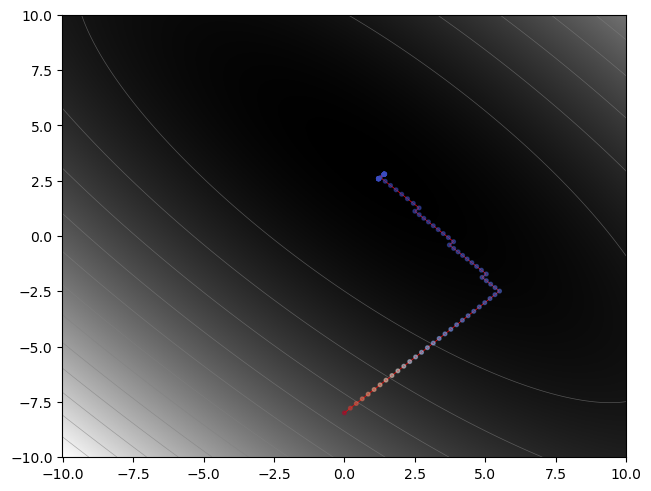

In [15]:
from visualbench.tasks.function_descent import FunctionDescent

f = FunctionDescent('booth')
opt = lambda p: tz.optim.Modular(
    p, 
    tz.m.Interpolate(
        [tz.m.AddMagnitude(1e-2), tz.m.Reciprocal(), tz.m.Normalize()], 
        [tz.m.Grad(), tz.m.Normalize()], 
        0.5
    ), 
    tz.m.LR(0.3)
)
f.run(opt(f.parameters()), 100)
f.plot_solution()

In [ ]:
opt = lambda p: tz.optim.Modular(p, tz.m.Interpolate(tz.m.Grad(), [tz.m.AddMagnitude(1e-2), tz.m.Reciprocal(), tz.m.Normalize()], 0.5), tz.m.LR(1e-1))
_test_optimizer(opt)        